#### If this is your first run and you are only reproducing the results, do the following
1. Run svd_w2v2_init.py
2. Run svd_w2v2.ipynb

#### If this is your first run and you are reproducing the training and results, do the following
1. Run svd_w2v2_init.py
2. Run svd_w2v2.ipynb till cell 14
3. Run svd_w2v2_train.py
4. Run remaining two cells (15 and 16) of svd_w2v2.ipynb

In [1]:
import librosa
from transformers import (
    Wav2Vec2ForCTC,
    Wav2Vec2Processor,
    Wav2Vec2Config,
)
import torch
import pandas as pd
from pycaret.classification import *
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import copy
import random
import os

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
def set_seed(seed = 0):
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state

seed=1112
random_state = set_seed(seed)

In [3]:
class SVDDataset(torch.nn.Module):
    def __init__(self, df, processor, duration):
      self.samples = df['path'].to_numpy()
      self.processor = processor
      self.duration = duration
    
    def __getitem__(self,idx):
      speech_array, sampling_rate = librosa.load(self.samples[idx], sr=16_000, duration=self.duration)
      input = self.processor(speech_array, 
                             sampling_rate=sampling_rate, 
                             return_tensors="pt",
                             padding=True,
                             )
      return input
    
    def __len__(self):
        return len(self.samples)

In [4]:
def get_vector(hidden_layers_form_arch, mode='average', top_n_layers=4):
  '''
  retrieve vectors for a token_index from the top n layers and return a concatenated, averaged or summed vector 
  hidden_layers_form_arch: tuple returned by the transformer library
  token_index: index of the token for which a vector is desired
  mode=
        'average' : avg last n layers
        'concat': concatenate last n layers
        'sum' : sum last n layers
        'last': return embeddings only from last layer
        'second_last': return embeddings only from second last layer
  top_n_layers: number of top layers to concatenate/ average / sum
  '''
  if mode == 'concat':
    # for each token/sequence concatenate the last for layers embeddings -> returns [batch_size x seq_len x dim]
    return torch.cat(hidden_layers_form_arch[-top_n_layers:], dim=2)
  
  if mode == 'average':
    # for each token/sequence take mean of last 4 layers embeddings -> returns [batch_size x seq_len x dim]
    return torch.stack(hidden_layers_form_arch[-top_n_layers:]).mean(0)

  if mode == 'sum':
    # for each token/sequence take sum of last 4 layers embeddings -> returns [batch_size x seq_len x dim]
    return torch.stack(hidden_layers_form_arch[-top_n_layers:]).sum(0)

  if mode == 'last':
    # for each token/sequence take only the last layer embeddings -> returns [batch_size x seq_len x dim]
    return hidden_layers_form_arch[-1:][0]

  if mode == 'second_last':
    # for each token/sequence take only the second last layer embeddings -> returns [batch_size x seq_len x dim]
    return hidden_layers_form_arch[-2:-1][0]

  return None

In [5]:
def get_embeddings_df(df, model_id, mode='average', batch_size=10, duration=120, device='cpu'):
  config = Wav2Vec2Config.from_pretrained(model_id)
  config.output_hidden_states = True
  config.return_dict = True
  model = Wav2Vec2ForCTC.from_pretrained(model_id, config=config).to(device)
  processor=Wav2Vec2Processor.from_pretrained(model_id)

  ds = SVDDataset(df, processor, duration=duration)
  dl = torch.utils.data.DataLoader(ds, batch_size = batch_size, shuffle=False, num_workers = 2, pin_memory=True, drop_last=False)

  embeddings = []
  with torch.no_grad():
    for batch_number, batch in enumerate(dl):
      inputs = {key: torch.squeeze(val, dim=1).to(device) for key, val in batch.items()}
      outputs = model(inputs['input_values'], attention_mask=inputs['attention_mask'])
      hidden_layers = outputs.hidden_states
      token_vectors = get_vector(outputs.hidden_states, mode=mode)
      # print(token_vectors.shape)
      # token vectors have shape of [batch_size x seq_len x dim].
      # we need to get average/mean of all the tokens/sequence to generate 
      # speech/sentence vector. This is done by applying mean on dim=1. 
      # dim 0 is batch_size, dim 1 is seq_len and dim 2 is embedding_size/dim
      embeddings.extend(torch.mean(token_vectors, dim=1).detach().cpu().numpy())
  return embeddings

In [6]:
model_id = 'jonatasgrosman/wav2vec2-large-xlsr-53-german'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df = pd.read_csv('../data/svd_speech/voice_samples/svd_w2v2_dataset.csv')
df.shape

(1988, 4)

In [7]:
df.value_counts(['target'], normalize=True)

target   
pathology    0.681087
healthy      0.318913
dtype: float64

In [8]:
df.value_counts(['target', 'sex'], normalize=True)

target     sex
pathology  0      0.365191
           1      0.315895
healthy    0      0.192153
           1      0.126761
dtype: float64

In [9]:
print('Looking at mean of voice recording duration, overall and sub-groups')
print()
print('='*30)
print('overall mean:', df['duration'].mean())
print('='*30)
print()
print('='*30)
print('Healthy samples mean:', df.loc[(df.target == 'healthy'), ['duration']].mean())
print('Pathological samples mean:', df.loc[(df.target == 'pathology'), ['duration']].mean())
print('='*30)
print()
print('='*30)
print('Healthy female samples mean:', df.loc[(df.target == 'healthy') & (df.sex == 0), ['duration']].mean())
print('Pathological female samples mean:', df.loc[(df.target == 'pathology') & (df.sex == 0), ['duration']].mean())
print('='*30)
print()
print('='*30)
print('Healthy male samples mean:', df.loc[(df.target == 'healthy') & (df.sex == 1), ['duration']].mean())
print('Pathological male samples mean:', df.loc[(df.target == 'pathology') & (df.sex == 1), ['duration']].mean())
print('='*30)

Looking at mean of voice recording duration, overall and sub-groups

overall mean: 2.173884366197183

Healthy samples mean: duration    1.851918
dtype: float64
Pathological samples mean: duration    2.324643
dtype: float64

Healthy female samples mean: duration    1.840343
dtype: float64
Pathological female samples mean: duration    2.329902
dtype: float64

Healthy male samples mean: duration    1.869465
dtype: float64
Pathological male samples mean: duration    2.318562
dtype: float64


In [10]:
print('Looking at max of voice recording duration, overall and sub-groups')
print()
print('='*30)
print('overall max:', df['duration'].max())
print('='*30)
print()
print('='*30)
print('Healthy samples max:', df.loc[(df.target == 'healthy'), ['duration']].max())
print('Pathological samples max:', df.loc[(df.target == 'pathology'), ['duration']].max())
print('='*30)
print()
print('='*30)
print('Healthy female samples max:', df.loc[(df.target == 'healthy') & (df.sex == 0), ['duration']].max())
print('Pathological female samples max:', df.loc[(df.target == 'pathology') & (df.sex == 0), ['duration']].max())
print('='*30)
print()
print('='*30)
print('Healthy male samples max:', df.loc[(df.target == 'healthy') & (df.sex == 1), ['duration']].max())
print('Pathological male samples max:', df.loc[(df.target == 'pathology') & (df.sex == 1), ['duration']].max())
print('='*30)

Looking at max of voice recording duration, overall and sub-groups

overall max: 6.371919999999999

Healthy samples max: duration    4.14034
dtype: float64
Pathological samples max: duration    6.37192
dtype: float64

Healthy female samples max: duration    4.14034
dtype: float64
Pathological female samples max: duration    6.35934
dtype: float64

Healthy male samples max: duration    3.9032
dtype: float64
Pathological male samples max: duration    6.37192
dtype: float64


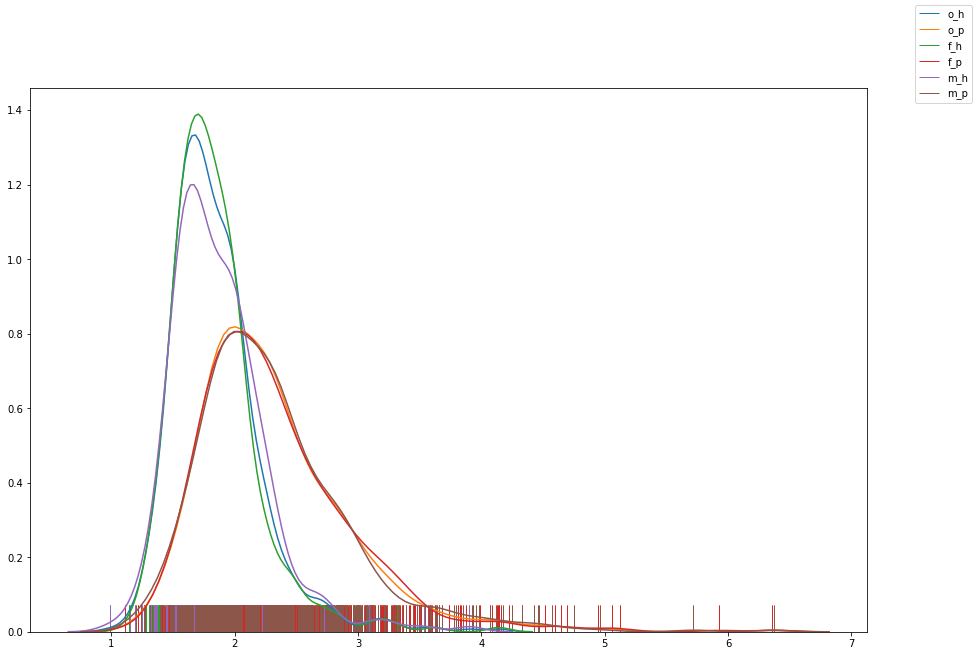

In [11]:
overall_healthy = df.loc[(df.target == 'healthy'), ['duration']]
overall_pathology = df.loc[(df.target == 'pathology'), ['duration']]
female_healthy = df.loc[(df.target == 'healthy') & (df.sex == 0), ['duration']]
female_pathology = df.loc[(df.target == 'pathology') & (df.sex == 0), ['duration']]
male_healthy = df.loc[(df.target == 'healthy') & (df.sex == 1), ['duration']]
male_pathology = df.loc[(df.target == 'pathology') & (df.sex == 1), ['duration']]

fig = pyplot.figure(figsize=(15,10))
sns.distplot(overall_healthy, hist=False, rug=True)
sns.distplot(overall_pathology, hist=False, rug=True)
sns.distplot(female_healthy, hist=False, rug=True)
sns.distplot(female_pathology, hist=False, rug=True)
sns.distplot(male_healthy, hist=False, rug=True)
sns.distplot(male_pathology, hist=False, rug=True)
fig.legend(labels=['o_h', 'o_p', 'f_h', 'f_p', 'm_h', 'm_p'])
pyplot.show()

In [12]:
speech_embeddings = get_embeddings_df(df=df, model_id=model_id, mode='concat', batch_size=1, duration=1.9, device=device)
target = df.target.map({'healthy': 1, 'pathology': 0})

In [13]:
columns = []
for i in range(speech_embeddings[0].shape[0]):
  columns.append(str(i))

processed_df = pd.DataFrame(data=speech_embeddings, columns=columns)
processed_df['target'] = target

processed_df.shape

(1988, 4097)

In [14]:
processed_df.to_csv(path_or_buf='../data/svd_speech/voice_samples/svd_w2v2_processed.csv', index=False, header=True)

train, test = train_test_split(processed_df, test_size=0.2)
print(train.shape)
print(test.shape)

(1590, 4097)
(398, 4097)


### Run all the above cells to generate processed data

In [15]:
blend_model = load_model('blend_estimator')
X = copy.deepcopy(test)
X.drop(columns=['target'], axis=1, inplace=True)
y = copy.deepcopy(test['target'])

y_pred = blend_model.predict(X)
y_proba = blend_model.predict_proba(X)[:,1]
print('Blend model accuracy: ', accuracy_score(y, y_pred))
print('Blend model AUC: ', roc_auc_score(y, y_proba))
print('Blend model f1 score: ', f1_score(y, y_pred))

Transformation Pipeline and Model Successfully Loaded
Blend model accuracy:  0.9120603015075377
Blend model AUC:  0.9696550506239698
Blend model f1 score:  0.8616600790513833


In [16]:
stack_model = load_model('stacked_estimator')
X = copy.deepcopy(test)
X.drop(columns=['target'], axis=1, inplace=True)
y = copy.deepcopy(test['target'])

y_pred = stack_model.predict(X)
y_proba = stack_model.predict_proba(X)[:,1]
print('Stack model accuracy: ', accuracy_score(y, y_pred))
print('Stack model AUC: ', roc_auc_score(y, y_proba))
print('Stack model f1 score: ', f1_score(y, y_pred))

Transformation Pipeline and Model Successfully Loaded
Stack model accuracy:  0.8994974874371859
Stack model AUC:  0.9587355780550977
Stack model f1 score:  0.8387096774193549
